# Remove the comments on the following section to install all the required libraries to run this project.

In [369]:
# %pip install scikit-learn
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn

## Imports the will be used for the whole project

In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

In [371]:
### Loading the Dataset
data = pd.read_csv("House_Rent_Dataset.csv")
data

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2,15000,1000,3 out of 5,Carpet Area,Bandam Kommu,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner
4742,2022-05-15,3,29000,2000,1 out of 4,Super Area,"Manikonda, Hyderabad",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4743,2022-07-10,3,35000,1750,3 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent
4744,2022-07-06,3,45000,1500,23 out of 34,Carpet Area,Gachibowli,Hyderabad,Semi-Furnished,Family,2,Contact Agent


## Data Preprocessing

In [372]:
data = data[['BHK', 
            'Bathroom', 
            'Furnishing Status', 
            'Area Type', 
            'City', 
            'Size', 
            'Floor', 
            'Tenant Preferred', 
            'Point of Contact', 
            # 'Area Locality', 
            'Rent']]

In [373]:
# Give ground and basement floors numerical values
def replace_ground_basement(row):
    if 'Ground' in row:
        return row.replace("Ground", '1')
    elif "Upper Basement" in row:
        return row.replace("Upper Basement", '2')
    elif "Lower Basement" in row:
        return row.replace("Lower Basement", '1')
    else:
        return row

'''   
First thought is to make basement values as negative but changed my way thinking and just counted the basement values as part of the total number of floors 
'''
# Replace " out of " with '/' to make it easier to evaluate the floors
def replace_out_of(row):
    if " out of " not in row:
        return '1'
    else:
        return row.replace(" out of ", '/')

'''
I created my own evaluate function to handle ZeroDivisionError
'''
def evaluate_fraction(row):
    try:
        return eval(row)
    except ZeroDivisionError:
        return None

# This is to check if there are rows that the left value is greater than the total floor and switch its placement
def check_greater_left_value(row):
    if " out of " in row:
        test = row.split(" out of ")
        if int(test[0]) > int(test[1]):
            print(test)
            row = "{} out of {}".format(test[1], test[0])
            return row
        else:
            return row
    else:
        return row
    
'''
I chose to switch the placement of the floors because I assumed that this happened because of human error
'''

# This is to check if the evaluation of floors resulted in a value greater than 1
def check_gereater_than_1(row):
    if row > 1:
        print(row)
    return row

### Data Cleaning for Floor column

In [374]:
data['Floor'] = data['Floor'].apply(replace_ground_basement)
data['Floor'] = data['Floor'].apply(check_greater_left_value)
data['Floor'] = data['Floor'].apply(replace_out_of)
data['Floor'] = data['Floor'].apply(evaluate_fraction)
data['Floor'] = data['Floor'].apply(check_gereater_than_1)

['8', '5']
['2', '1']


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_20880\2394960642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Floor'] = data['Floor'].apply(replace_ground_basement)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_20880\2394960642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Floor'] = data['Floor'].apply(check_greater_left_value)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_20880\2394960642.py:3: SettingWithCopyWarning: 
A value is trying to be set o

## One Hot Encoding the columns without numerical value

In [375]:
def one_hot_encode(data, column, suffix=''):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded, lsuffix='_data', rsuffix='_encoded')
    # data = data.join(encoded)
    return data

data = one_hot_encode(data, 'Furnishing Status')
data = one_hot_encode(data, 'Area Type')
data = one_hot_encode(data, 'City')
data = one_hot_encode(data, 'Tenant Preferred')
data = one_hot_encode(data, 'Point of Contact')

## Removing outliers from rent column using z-scores

In [376]:
z = np.abs(stats.zscore(data['Rent']))
print(z)
threshold_z = 2
print("Original DataFrame Shape:", data.shape)
outlier_indices = np.where(z > threshold_z)[0]
data = data.drop(outlier_indices)
print("DataFrame Shape after Removing Outliers:", data.shape)
data

0       0.320026
1       0.191982
2       0.230395
3       0.320026
4       0.352037
          ...   
4741    0.256004
4742    0.076743
4743    0.000084
4744    0.128128
4745    0.256004
Name: Rent, Length: 4746, dtype: float64
Original DataFrame Shape: (4746, 18)
DataFrame Shape after Removing Outliers: (4632, 18)


,BHK,Bathroom,Size,Floor,Rent,Semi-Furnished,Unfurnished,Carpet Area,Super Area,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Bachelors/Family,Family,Contact Builder,Contact Owner
0,2,2,1100,0.500000,10000,False,True,False,True,False,False,False,True,False,True,False,False,True
1,2,1,800,0.333333,20000,True,False,False,True,False,False,False,True,False,True,False,False,True
2,2,1,1000,0.333333,17000,True,False,False,True,False,False,False,True,False,True,False,False,True
3,2,1,800,0.500000,10000,False,True,False,True,False,False,False,True,False,True,False,False,True
4,2,1,850,0.500000,7500,False,True,True,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2,2,1000,0.600000,15000,True,False,True,False,False,False,True,False,False,True,False,False,True
4742,3,3,2000,0.250000,29000,True,False,False,True,False,False,True,False,False,True,False,False,True
4743,3,3,1750,0.600000,35000,True,False,True,False,False,False,True,False,False,True,False,False,False
4744,3,2,1500,0.676471,45000,True,False,True,False,False,False,True,False,False,False,True,False,False


## Training and Test split

In [377]:
X = data.drop('Rent', axis= 1)
y = data['Rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=350)

## Standardize the values using PolynomialFeatures

In [378]:
sc = PolynomialFeatures()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Modelling

In [379]:
# Test a variety of penalty value using Ridge Cross-Validation to find the most suitable alpha value
alphas = [30, 20, 10, 15, 25, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 175, 200, 225, 250, 275, 300, 400, 500]
sample_model = RidgeCV(alphas=alphas, store_cv_values=True)
sample_model.fit(X_train, y_train)
optimal_alpha = sample_model.alpha_
print(optimal_alpha)

# model = linear_model.LinearRegression()
model = linear_model.Ridge(alpha=optimal_alpha)
model.fit(X_train, y_train)
model.coef_

20


array([ 0.00000000e+00, -1.21669305e+03, -1.74972147e+03,  2.89206480e+01,
       -1.75502768e+03, -1.79913689e+03, -5.50991381e+02, -7.75126854e+02,
        7.75088940e+02,  2.36429248e+03, -9.51253270e+02,  4.83383173e+02,
       -1.33848322e+03,  3.21050261e+02, -6.04077234e+00, -2.07516532e+03,
       -1.74634824e-02,  1.79534730e+03,  7.72315343e+02,  3.13427935e+03,
       -8.85942346e+00,  3.21160424e+03,  1.99090812e+03,  1.01460062e+03,
       -1.05520661e+03, -1.61524361e+02,  2.16736893e+03,  2.46966557e+02,
        2.55481924e+03,  2.68782839e+03, -4.47271642e+03, -1.69847295e+03,
       -1.51514414e+03, -1.74634824e-02, -6.27254820e+02, -1.41020354e+03,
        5.59123587e+00,  3.00216756e+03, -1.86803633e+02,  4.86820842e+02,
        2.63862658e+02, -2.01362204e+03, -4.31291402e+02,  8.79382196e+03,
       -1.06285877e+03,  8.94962275e+02, -3.10836185e+02,  4.69199762e+02,
        2.92662632e+02, -1.74634824e-02, -4.31265273e+03,  3.54894430e-03,
       -7.50562148e+00, -

# Evaluation

## Quantitative Evaluation

In [380]:
print(f"Regression-Training set score: {model.score(X_train, y_train):.2f}")
print(f"Regression-Test set score: {model.score(X_test, y_test):.2f}")

Regression-Training set score: 0.78
Regression-Test set score: 0.80


In [381]:
### Quantitative Evaluation
y_preds = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds))

Coefficients: 
 [ 0.00000000e+00 -1.21669305e+03 -1.74972147e+03  2.89206480e+01
 -1.75502768e+03 -1.79913689e+03 -5.50991381e+02 -7.75126854e+02
  7.75088940e+02  2.36429248e+03 -9.51253270e+02  4.83383173e+02
 -1.33848322e+03  3.21050261e+02 -6.04077234e+00 -2.07516532e+03
 -1.74634824e-02  1.79534730e+03  7.72315343e+02  3.13427935e+03
 -8.85942346e+00  3.21160424e+03  1.99090812e+03  1.01460062e+03
 -1.05520661e+03 -1.61524361e+02  2.16736893e+03  2.46966557e+02
  2.55481924e+03  2.68782839e+03 -4.47271642e+03 -1.69847295e+03
 -1.51514414e+03 -1.74634824e-02 -6.27254820e+02 -1.41020354e+03
  5.59123587e+00  3.00216756e+03 -1.86803633e+02  4.86820842e+02
  2.63862658e+02 -2.01362204e+03 -4.31291402e+02  8.79382196e+03
 -1.06285877e+03  8.94962275e+02 -3.10836185e+02  4.69199762e+02
  2.92662632e+02 -1.74634824e-02 -4.31265273e+03  3.54894430e-03
 -7.50562148e+00 -8.52740044e+00 -1.06823530e+01  6.12136333e+00
  3.84225666e+00 -5.14426125e+00 -9.39304280e+00 -1.02927462e+01
 -1.15558

## Qualitative Evaluation

In [382]:
### Qualitative Evaluation
sample_data = X.iloc[0]

sample_data_standardized = sc.transform(X.iloc[0].values.reshape(1,-1))
sample_data_standardized

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([[1.00e+00, 2.00e+00, 2.00e+00, 1.10e+03, 5.00e-01, 0.00e+00,
        1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        4.00e+00, 4.00e+00, 2.20e+03, 1.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 2.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 2.00e+00, 0.00e+00, 0.00e+00, 2.00e+00, 4.00e+00,
        2.20e+03, 1.00e+00, 0.00e+00, 2.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 0.00e+00, 2.00e+00, 1.21e+06, 5.50e+02, 0.00e+00,
        1.10e+03, 0.00e+00, 1.10e+03, 0.00e+00, 0.00e+00, 0.00e+00,
        1.10e+03, 0.00e+00, 1.10e+03, 0.00e+00, 0.00e+00, 1.10e+03,
        2.50e-01, 0.00e+00, 5.00e-01, 0.00e+00, 5.00e-01, 0.00e+00,
        0.00e+00, 0.00e+00, 5.00e-01, 0.00e+00, 5.00e-01, 0.00e+00,
        0.00e+00, 5.00e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

In [383]:
model_rent_forecast = model.predict(sample_data_standardized)[0]
model_rent_forecast

print(f'Rent forecast made by the model: {model_rent_forecast}')
print(f'Actual rent: {y.iloc[0]}')

Rent forecast made by the model: 11889.835249606687
Actual rent: 10000


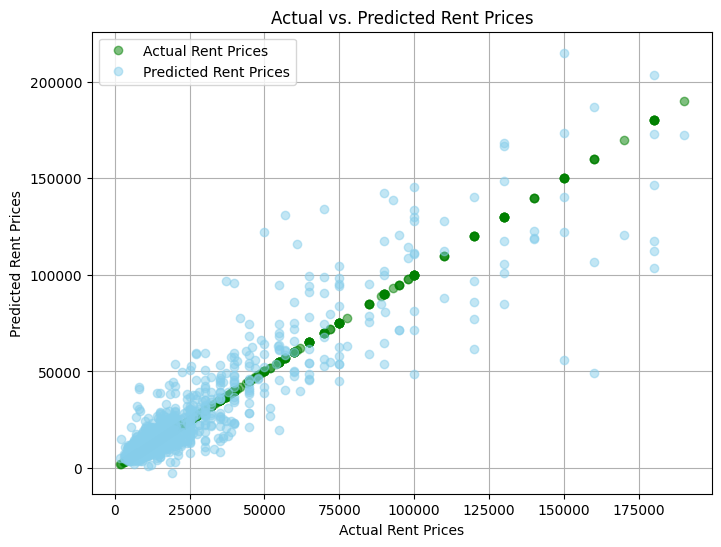

In [384]:
plt.figure(figsize=(8,6))
plt.plot(y_test, y_test, 'o', alpha=0.5, color='green', label='Actual Rent Prices')
plt.plot(y_test, y_preds, 'o', alpha=0.5, color='skyblue', label='Predicted Rent Prices')

plt.title("Actual vs. Predicted Rent Prices")
plt.xlabel("Actual Rent Prices")
plt.ylabel("Predicted Rent Prices")

plt.legend()
plt.grid(True)
plt.show()